In [181]:
#Import Statements
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output 
from IPython.display import Image
import os
from os import path
import pandas as pd
from scipy.signal import find_peaks
import glob
import math

#### Functions

In [184]:
def fits_data_to_3d_array(file_list): 
    '''
    Takes in a list of fits files and converts data into a 3d array
    Parameters:
        file_list (list): List containing paths of FITS files to convert.
    Returns:
        final_array: 3d array of data from each fits file.
    '''    
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#Creates a median combine of a 3d array
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
 
def save_array_to_fits_file(array, new_file_name):
    '''
    Saves a 2d array of pixel data to a FITS file.
    Parameters:
    array(2d): 2d array containing pixel values.
    new_file_name (path): location, name of FITS file to be saved.
    '''  
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name,overwrite=True)


def glob_files(folder, specifier, asterisks='both', show=False):
    asterisk = "*"
    if asterisks == 'both':
        files = glob.glob(os.path.join(folder, asterisk + specifier + asterisk))
    elif asterisks == 'left':
        files = glob.glob(os.path.join(folder, asterisk + specifier))
    elif asterisks == 'right':
        files = glob.glob(os.path.join(folder, specifier + asterisk))
    if show:
        print(f'Number of Files: {len(files)}')
        for file in files: 
            print(file)
    return files

def cut_pixel_data_array(pixel_data_array, y_pixel_min, y_pixel_max):
    '''
    Returns an array of pixel data, cut to a specified vertical (y-pixel) range.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to create a cut from.
        y_pixel_min (int): Lower bound to start cut. 
        y_pixel_max (int): Upper bound to end cut. 
    Returns:
        final_array: 3d array of data from each fits file.
    '''   
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    pixel_data_array_cut = pixel_data_array[lower_index:upper_index,:]
    print(pixel_data_array_cut.shape)
    return pixel_data_array_cut

def display_2d_array(pixel_data_array, figsize=(7,3), lower_percentile=1, upper_percentile=99,title='2D Array'):
    '''
    Displays a 2d array of pixel data. Useful to see the image contained in a FITS file,
    or to verify successful array data handling.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to display.
        lower_percentile (int): Adjusts the pixel scale lower bound; default = 1
        upper_percentile (int): Adjusts the pixel scale upper bound; default = 99
    '''   
    fig, ax = plt.subplots(figsize=figsize)
    minimum = np.percentile(pixel_data_array,lower_percentile)
    maximum = np.percentile(pixel_data_array,upper_percentile)
    img = ax.imshow(pixel_data_array, cmap='gray', origin = 'lower', vmin=minimum, vmax=maximum)
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label('Pixel Counts/Intensity')
    plt.title(title)

def darks_correction(mcombine_array, darks_mcombine_array):
    return mcombine_array - darks_mcombine_array

def calibrate_fits_files(fits_file_list=[], output_3d_only=False, output_mcombine_only=True, output_darks_corrected=True,
                         mcombine_array=None, darks_array=None, display_array=False):
    '''
    Function is multifunctional. It can:
    1) Output a 3d array
    2) Output a median combine (2d)
    3) Output a darks corrected array (2d)

    fits_file_list([]) : List containing paths of FITS files to convert.
    output_3d_only(True/False) : Output only 3d array
    output_mcombine_only(True/False) : Output only mcombine array
    output_darks_corrected(True/False) : Output only darks corrected array
    mcombine_array : 
    darks_array :
    display_array(True/False) :
    '''
    if output_3d_only:
        array_3d = fits_data_to_3d_array(fits_file_list)
        return array_3d
    elif output_mcombine_only:
        array_3d = fits_data_to_3d_array(fits_file_list)
        array_mcombine = median_combine(array_3d)
        if display_array:
            display_2d_array(array_mcombine)
        return array_mcombine
    elif output_darks_corrected:
        final_array = darks_correction(mcombine_array - darks_array)
        if display_array:
            display_2d_array(final_array)
        return final_array
def display_cut_spectrum(pixel_data_array, figsize=(12,5), lower_percentile=1, upper_percentile=99, title='2D Array'):
    '''
    Displays a 2d array of pixel data. Useful to see the image contained in a FITS file,
    or to verify successful array data handling.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to display.
        lower_percentile (int): Adjusts the pixel scale lower bound; default = 1
        upper_percentile (int): Adjusts the pixel scale upper bound; default = 99
    '''   
    fig, ax = plt.subplots(figsize=figsize)
    minimum = np.percentile(pixel_data_array,lower_percentile)
    maximum = np.percentile(pixel_data_array,upper_percentile)
    img = ax.imshow(pixel_data_array, cmap='gist_gray', origin = 'lower', vmin=minimum, vmax=maximum)
    #seismic RdGy gist_gray
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.1, fraction=.05, aspect=50)
    cbar.set_label('Pixel Counts/Intensity')
    fig.tight_layout
    plt.title(title)

def cut_pixel_data_array_3d(pixel_data_array, y_pixel_min, y_pixel_max):
    '''
    Returns an array of pixel data, cut to a specified vertical (y-pixel) range.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to create a cut from.
        y_pixel_min (int): Lower bound to start cut. 
        y_pixel_max (int): Upper bound to end cut. 
    Returns:
        final_array: 3d array of data from each fits file.
    '''   
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    pixel_data_array_cut = pixel_data_array[:, lower_index:upper_index, :]
    return pixel_data_array_cut

def plot_spectrum(spectrum_label, index_set, invert_spectrum=False, find_peaks=False, plot_Habg_balmer=[False, False, False], 
                  xlim=[], ylim=[], legend_loc='upper right', peaks_height=(0, 0.35), dy=0):
    '''
    spectrum_label : Ne_set1 Ne_set2 Ha_set1 Ha_set2 Ar_set1 Ar_set2 Hbg_set1 Hbg_set2
    index_set : Ne_x_index_set1 Ne_x_index_set2 Ar_x_index_set1 Ar_x_index_set2
    '''
    if invert_spectrum:
        c = -1.0
        d = 1.0
    else:
        c = 1.0
        d = 0.0
    spectrum_index = np.arange(len(normalized_spectra[spectrum_label]))  # pixel index
    spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[index_set])  # pixel index --> wavelength index
    
    if find_peaks:
        # Find Peaks
        peaks, _ = find_peaks(normalized_spectra[spectrum_label], height=peaks_height)
        # Annotate peaks
        for peak in peaks:
            plt.annotate(f'{spectrum_wavelength_index[peak]:.1f} nm', 
                         (spectrum_wavelength_index[peak], normalized_spectra[spectrum_label][peak]), 
                         xytext=(0, 4), textcoords='offset points', ha='center', fontsize=7, color='red')

    plt.plot(spectrum_wavelength_index, c*normalized_spectra[spectrum_label]+d+dy, label=spectrum_label + ' Calibrated Spectrum')
    plt.ylabel('Intensity')
    plt.xlabel('Wavelength (nm)')
    plt.yticks(np.arange(0.0, 1.1, 0.1))

    if xlim != []: 
        plt.xlim(xlim)
    if ylim != []: 
        plt.ylim(ylim)

    # Plot Balmer Lines:
    if plot_Habg_balmer[0]:
        plt.vlines(x=656.3, ymin=0, ymax=1, color='r', label="Hα 656.3 nm")
    if plot_Habg_balmer[1]:
        plt.vlines(x=486.1, ymin=0, ymax=1, color='cyan', label="Hβ 486.1 nm")
    if plot_Habg_balmer[2]:
        plt.vlines(x=434, ymin=0, ymax=1, color='blue', label="Hγ 434 nm")

    plt.legend(loc=legend_loc)
    plt.grid(True)

## Creating Calibrated Science Images

### Creating Median Combine Dicts

Number of Files: 10
night_2\dark_60s.00000000.DARK.FIT
night_2\dark_60s.00000001.DARK.FIT
night_2\dark_60s.00000002.DARK.FIT
night_2\dark_60s.00000003.DARK.FIT
night_2\dark_60s.00000004.DARK.FIT
night_2\dark_60s.00000005.DARK.FIT
night_2\dark_60s.00000006.DARK.FIT
night_2\dark_60s.00000007.DARK.FIT
night_2\dark_60s.00000008.DARK.FIT
night_2\dark_60s.00000009.DARK.FIT
Number of Files: 10
night_2\dark_25s.00000000.DARK.FIT
night_2\dark_25s.00000001.DARK.FIT
night_2\dark_25s.00000002.DARK.FIT
night_2\dark_25s.00000003.DARK.FIT
night_2\dark_25s.00000004.DARK.FIT
night_2\dark_25s.00000005.DARK.FIT
night_2\dark_25s.00000006.DARK.FIT
night_2\dark_25s.00000007.DARK.FIT
night_2\dark_25s.00000008.DARK.FIT
night_2\dark_25s.00000009.DARK.FIT
Number of Files: 10
night_2\dark_15s.00000000.DARK.FIT
night_2\dark_15s.00000001.DARK.FIT
night_2\dark_15s.00000002.DARK.FIT
night_2\dark_15s.00000003.DARK.FIT
night_2\dark_15s.00000004.DARK.FIT
night_2\dark_15s.00000005.DARK.FIT
night_2\dark_15s.00000006.DARK

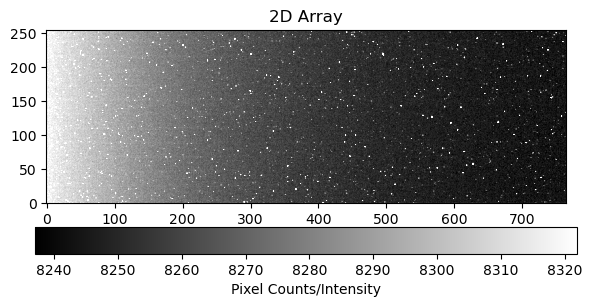

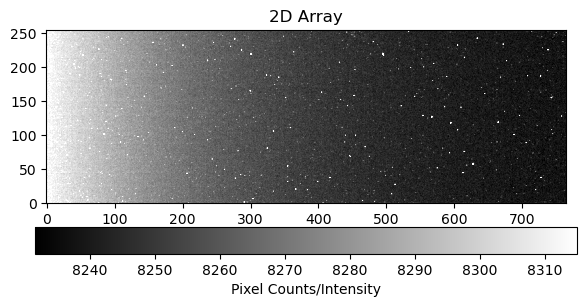

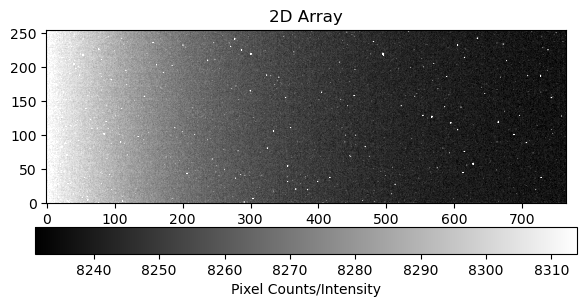

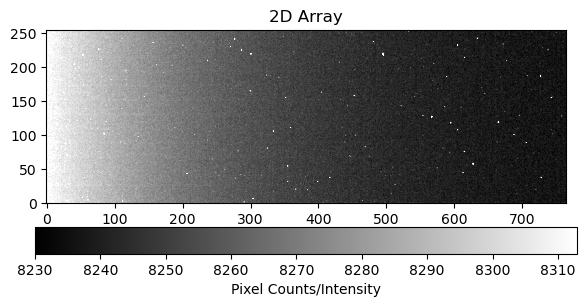

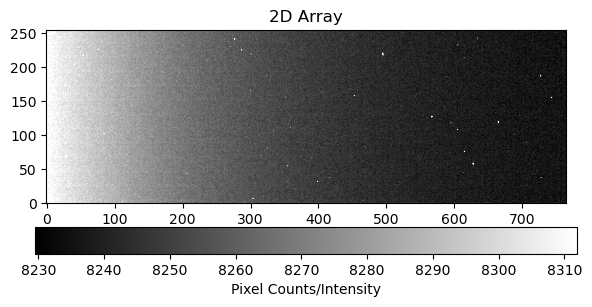

In [187]:
show_files = True
show_arrays = True
darks_exposure_times = ['dark_60s', 'dark_25s', 'dark_15s', 'dark_10s', 'dark_3s']
darks_mcombines = {}

for exposure in darks_exposure_times:
    fits_files = glob_files('night_2', exposure, show=show_files)
    darks_mcombines[exposure] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays)

for i in darks_mcombines:
    print(f"Avg pixel value in {i}: {np.mean(darks_mcombines[i])}")
    
print('Darks Median Combines')
for key, value in darks_mcombines.items():
    print(f"{key}, {np.shape(value)}")

Number of Files: 10
night_2\ha_neon_calibration_spectrum_set1_15s.00000000.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000001.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000002.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000003.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000004.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000005.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000006.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000007.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000008.FIT
night_2\ha_neon_calibration_spectrum_set1_15s.00000009.FIT
Number of Files: 10
night_2\ha_neon_calibration_spectrum_set2_15s.00000000.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000001.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000002.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000003.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000004.FIT
night_2\ha_neon_calibration_spectrum_set2_15s.00000005.FIT
night_2\ha_neon_

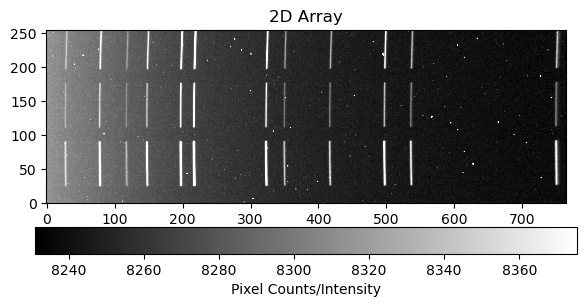

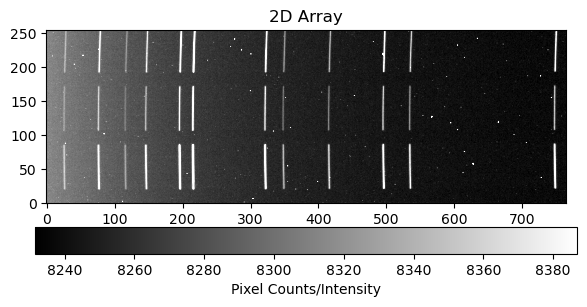

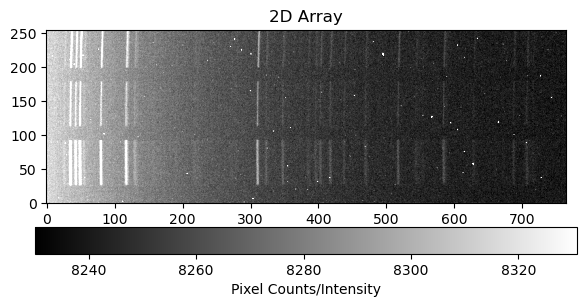

In [188]:
show_files = True
show_arrays = True
spectra = ['ha_neon_calibration_spectrum_set1', 'ha_neon_calibration_spectrum_set2_15s', 'hbg_argon_calibration_spectrum_sets1and2']
spectra_calib = {}
for spectrum in spectra:
    fits_files = glob_files('night_2', spectrum, show=show_files)
    spectra_calib[spectrum] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays)
new_keys = {
    'ha_neon_calibration_spectrum_set1': 'neon_set1_15s',
    'ha_neon_calibration_spectrum_set2_15s': 'neon_set2_15s',
    'hbg_argon_calibration_spectrum_sets1and2': 'argon_10s'
}
spectra_calib = {new_keys.get(old_key, old_key): value for old_key, value in spectra_calib.items()}
print('Spectra Median Combines')
for key, value in spectra_calib.items():
    print(f"{key}, {np.shape(value)}")

In [189]:
#display_2d_array(spectra_calib['argon_10s'])
#display_2d_array(darks_mcombines['dark_25s'])

Number of Files: 10
night_2\Ha_Neon_flats_3s.00000000.FIT
night_2\Ha_Neon_flats_3s.00000001.FIT
night_2\Ha_Neon_flats_3s.00000002.FIT
night_2\Ha_Neon_flats_3s.00000003.FIT
night_2\Ha_Neon_flats_3s.00000004.FIT
night_2\Ha_Neon_flats_3s.00000005.FIT
night_2\Ha_Neon_flats_3s.00000006.FIT
night_2\Ha_Neon_flats_3s.00000007.FIT
night_2\Ha_Neon_flats_3s.00000008.FIT
night_2\Ha_Neon_flats_3s.00000009.FIT
Number of Files: 5
night_2\hbg_flat_spectrum_sets1and2_60s.00000000.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000001.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000002.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000003.FIT
night_2\hbg_flat_spectrum_sets1and2_60s.00000004.FIT
Flats Median Combines
HaNe_flats_3s, (255, 765)
HbgAr_flats_60s, (255, 765)


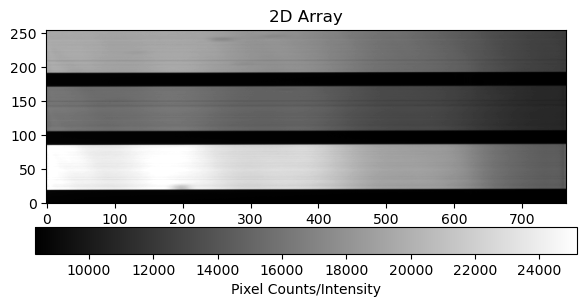

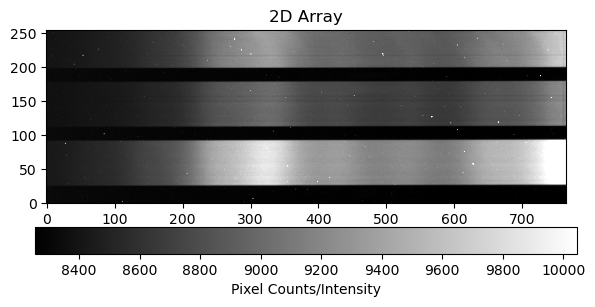

In [190]:
show_files = True
show_arrays = True
flats_names = ['Ha_Neon_flats_3s', 'hbg_flat_spectrum_sets1and2']
flats_mcombines = {}
for name in flats_names:
    fits_files = glob_files('night_2', name, show=show_files)
    flats_mcombines[name] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays)
new_keys = {
    'Ha_Neon_flats_3s': 'HaNe_flats_3s',
    'hbg_flat_spectrum_sets1and2': 'HbgAr_flats_60s',
}
flats_mcombines = {new_keys.get(old_key, old_key): value for old_key, value in flats_mcombines.items()}
print('Flats Median Combines')
for key, value in flats_mcombines.items():
    print(f"{key}, {np.shape(value)}")

Number of Files: 20
night_2\ha_lights_set1_25s.00000000.FIT
night_2\ha_lights_set1_25s.00000001.FIT
night_2\ha_lights_set1_25s.00000002.FIT
night_2\ha_lights_set1_25s.00000003.FIT
night_2\ha_lights_set1_25s.00000004.FIT
night_2\ha_lights_set1_25s.00000005.FIT
night_2\ha_lights_set1_25s.00000006.FIT
night_2\ha_lights_set1_25s.00000007.FIT
night_2\ha_lights_set1_25s.00000008.FIT
night_2\ha_lights_set1_25s.00000009.FIT
night_2\ha_lights_set1_25s.00000010.FIT
night_2\ha_lights_set1_25s.00000011.FIT
night_2\ha_lights_set1_25s.00000012.FIT
night_2\ha_lights_set1_25s.00000013.FIT
night_2\ha_lights_set1_25s.00000014.FIT
night_2\ha_lights_set1_25s.00000015.FIT
night_2\ha_lights_set1_25s.00000016.FIT
night_2\ha_lights_set1_25s.00000017.FIT
night_2\ha_lights_set1_25s.00000018.FIT
night_2\ha_lights_set1_25s.00000019.FIT
Number of Files: 20
night_2\ha_lights_set2_25s.00000000.FIT
night_2\ha_lights_set2_25s.00000001.FIT
night_2\ha_lights_set2_25s.00000002.FIT
night_2\ha_lights_set2_25s.00000003.FIT


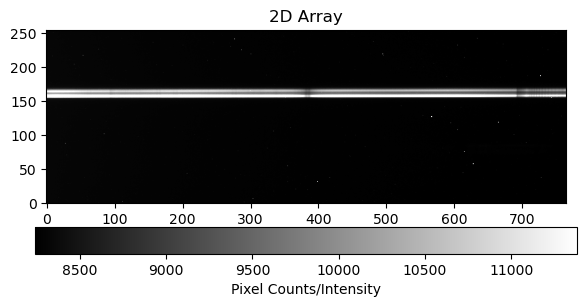

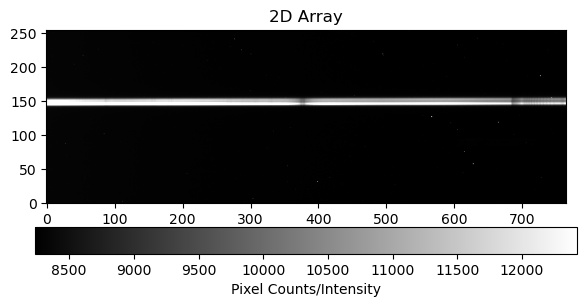

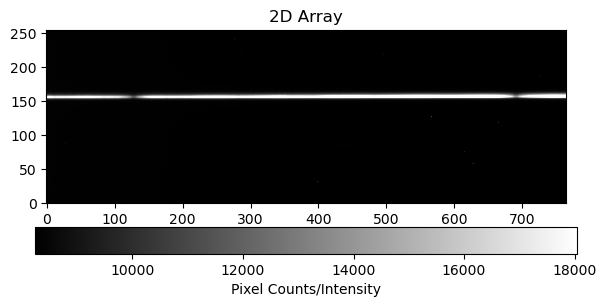

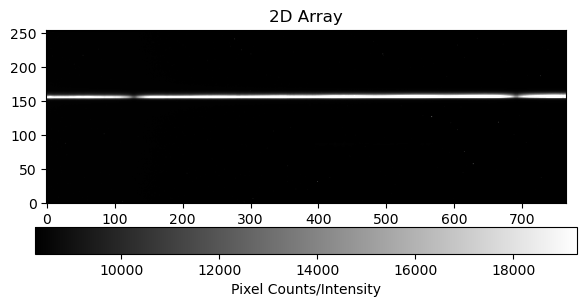

In [191]:
show_files = True
show_arrays = True
names = ['ha_lights_set1', 'ha_lights_set2', 'hbg_light_set1', 'hbg_light_set2']
sci_mcombines = {}
for name in names:
    fits_files = glob_files('night_2', name, show=show_files)
    sci_mcombines[name] = calibrate_fits_files(fits_file_list=fits_files, display_array=show_arrays) #
new_keys = {
    'ha_lights_set1': 'Ha_sci_set1',
    'ha_lights_set2': 'Ha_sci_set2',
    'hbg_light_set1': 'Hbg_sci_set1',
    'hbg_light_set2': 'Hbg_sci_set2',
}
sci_mcombines = {new_keys.get(old_key, old_key): value for old_key, value in sci_mcombines.items()}
print('Science Median Combines')
for key, value in sci_mcombines.items():
    print(f"{key}, {np.shape(value)}")

array([[8522. , 8537.5, 8529. , ..., 8305. , 8288. , 8285. ],
       [8531. , 8547. , 8542.5, ..., 8310.5, 8292.5, 8305. ],
       [8530.5, 8551. , 8536. , ..., 8273. , 8291. , 8295.5],
       ...,
       [8547.5, 8542. , 8525.5, ..., 8307.5, 8296.5, 8282.5],
       [8545. , 8557. , 8565. , ..., 8291. , 8309.5, 8287.5],
       [8561.5, 8551. , 8575. , ..., 8274. , 8303. , 8302. ]])

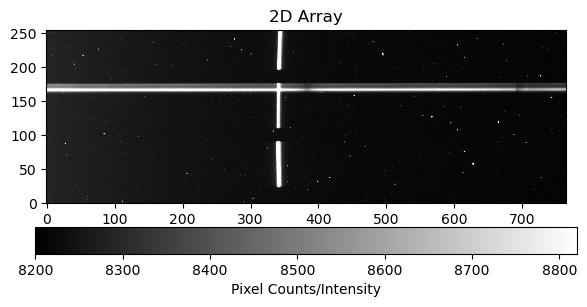

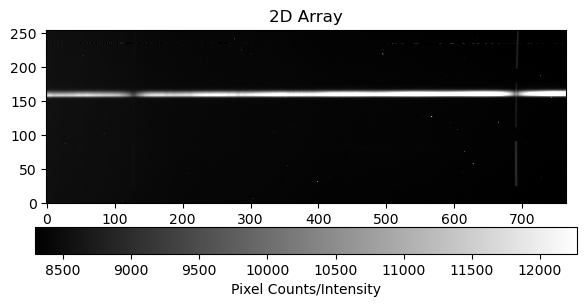

In [192]:
calibrate_fits_files(fits_file_list=glob_files('night_2','ha_laser_sanity'), display_array=True)
calibrate_fits_files(fits_file_list=glob_files('night_2','hbg_Hlamp_spectrum_sanity'), display_array=True)

Dicts: \
darks_mcombines \
spectra_calib \
flats_mcombines \
sci_mcombines

### Dark Correction
These will all be stored in dicts named
$\textit{name_dcorr}$

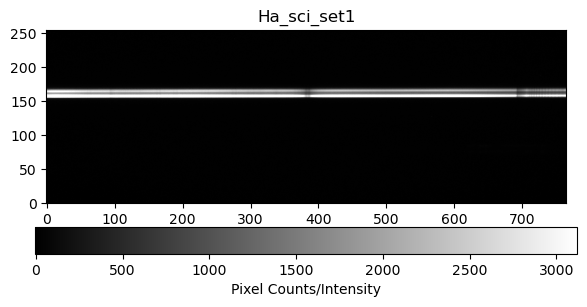

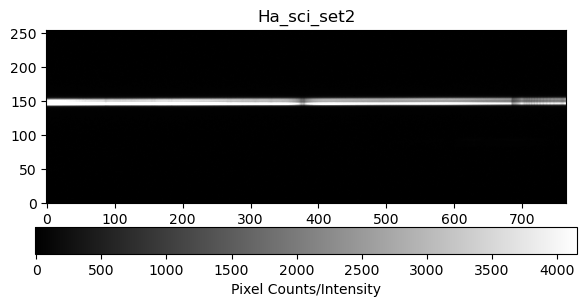

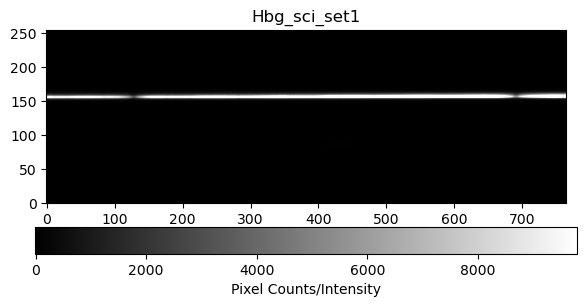

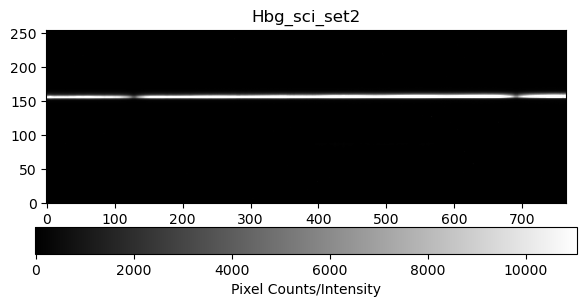

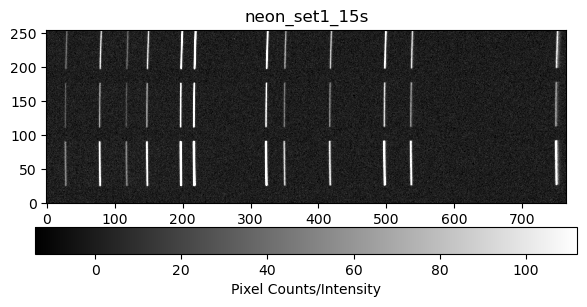

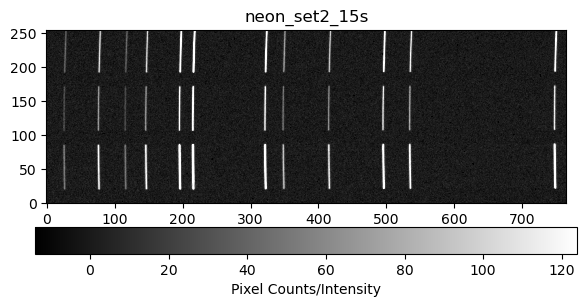

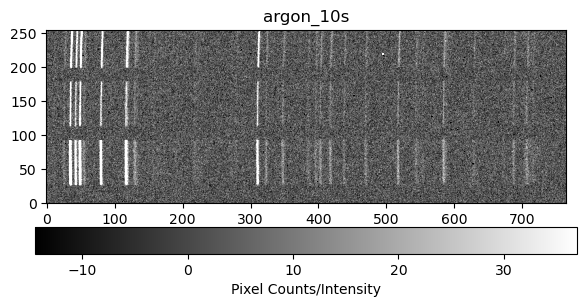

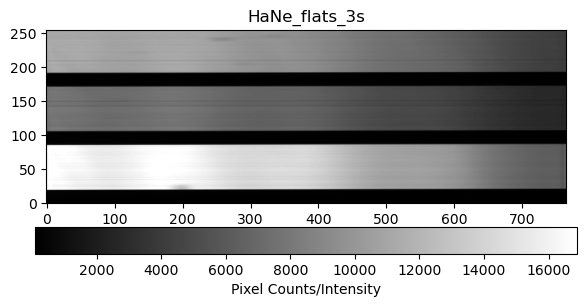

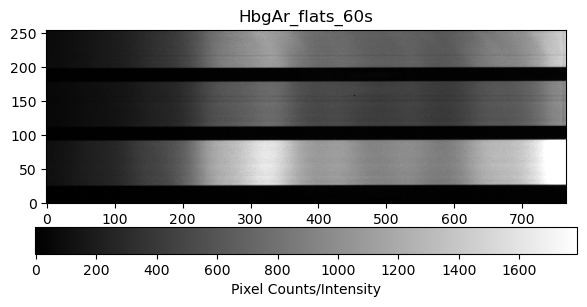

In [196]:
spectra_dcorr = spectra_calib.copy()
flats_dcorr = flats_mcombines.copy()
sci_dcorr = sci_mcombines.copy()
os.makedirs('calibrated_fits', exist_ok=True)

for key, value in sci_mcombines.items():
    sci_dcorr[key] = darks_correction(value, darks_mcombines['dark_25s'])
    display_2d_array(sci_dcorr[key], title=key)
    save_array_to_fits_file(sci_dcorr[key], path.join('calibrated_fits', 'sci_' + key + 'dark_correction.FIT'))

darks_order = ['dark_15s','dark_15s','dark_10s']
for (key, value), dark_key in zip(spectra_calib.items(), darks_order):
    spectra_dcorr[key] = darks_correction(value, darks_mcombines[dark_key])
    display_2d_array(spectra_dcorr[key], title=key)
    save_array_to_fits_file(spectra_dcorr[key], path.join('calibrated_fits', 'spec_' +  key + 'dark_correction.FIT'))

darks_order = ['dark_3s','dark_60s']
for (key, value), dark_key in zip(flats_mcombines.items(), darks_order):
    flats_dcorr[key] = darks_correction(value, darks_mcombines[dark_key])
    display_2d_array(flats_dcorr[key], title=key)
    save_array_to_fits_file(flats_dcorr[key], path.join('calibrated_fits', 'flat_' +  key + 'dark_correction.FIT'))

Now we have 3 dicts of dark corrected median combine frames: \
sci_dcorr \
spectra_dcorr \
flats_dcorr 

### Cut Arrays
We need to cut these arrays to only look at the slit, and region our star is in. \
Looking at ds9, here are the cut ranges for the science dark corrected spectra: \
\
H$\alpha$ (Set 1): \
pix_min = 154  &  pix_max = 169 \
H$\alpha$ (Set 2): \
pix_min = 142  &  pix_max = 155 \
H$\beta$, H$\gamma$ (Set 1): \
pix_min = 148  &  pix_max = 166 \
H$\beta$, H$\gamma$ (Set 2): \
pix_min = 145  &  pix_max = 170 

Lets cut these science arrays first

(15, 765)
(13, 765)
(18, 765)
(25, 765)
Ha_sci_set1, (15, 765)
Ha_sci_set2, (13, 765)
Hbg_sci_set1, (18, 765)
Hbg_sci_set2, (25, 765)


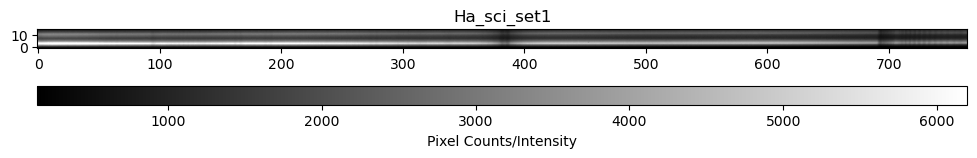

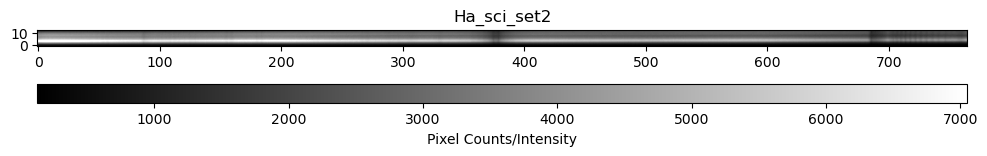

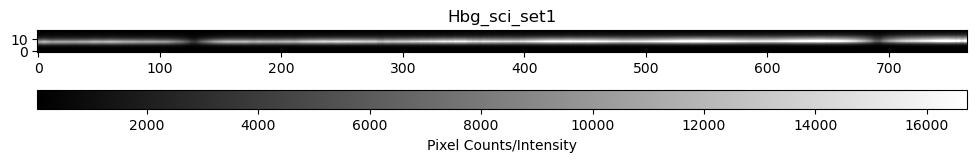

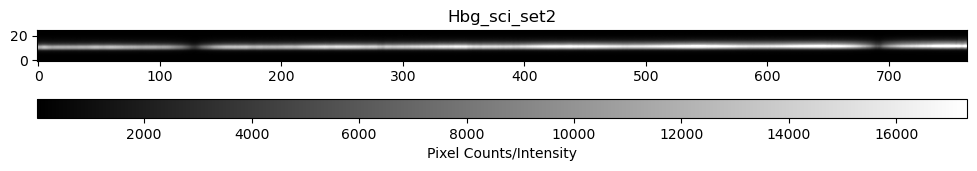

In [200]:
#Create a dict of cuts
cuts_dict = {'Ha_1' : [154,169],
             'Ha_2' : [142,155],
             'Hgb_1' : [148,166],
             'Hgb_2' : [145,170],
             }
#Create dicts to store cut arrays
sci_cut = sci_dcorr.copy()
os.makedirs('cut_fits', exist_ok=True) #New directory

#Perform cuts
for (key, value), cut_key in zip(sci_cut.items(), cuts_dict):
    sci_cut[key] = cut_pixel_data_array(value, *cuts_dict[cut_key])
    display_cut_spectrum(sci_cut[key], title=key)
    save_array_to_fits_file(sci_cut[key], path.join('cut_fits', 'sci_' +  key + '_cut.FIT'))

for key, value in sci_cut.items():
    print(f"{key}, {np.shape(value)}")

Now cut the flats and calibration spectra

(15, 765)
(13, 765)
(18, 765)
(25, 765)
(15, 765)
(13, 765)
(18, 765)
(25, 765)


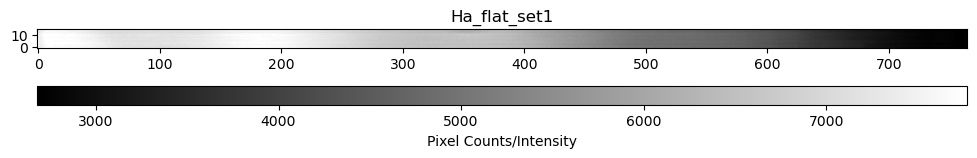

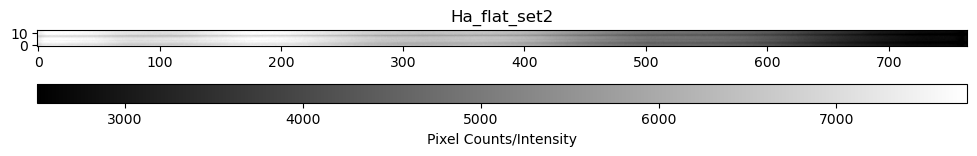

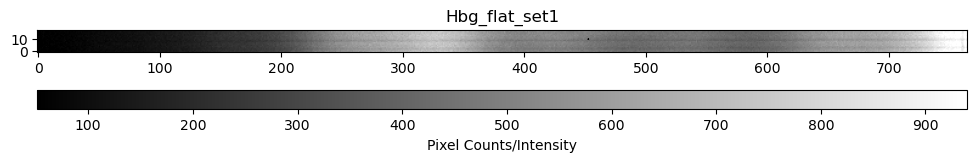

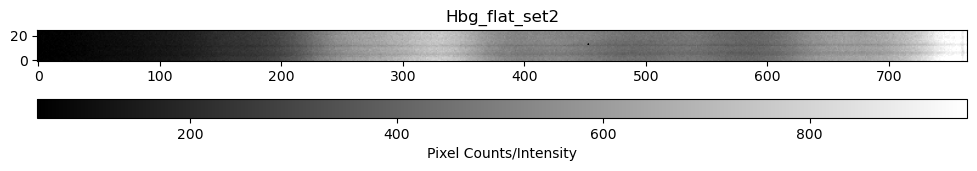

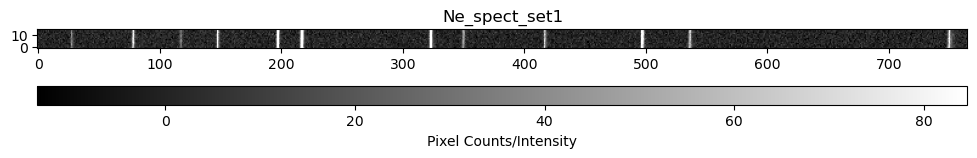

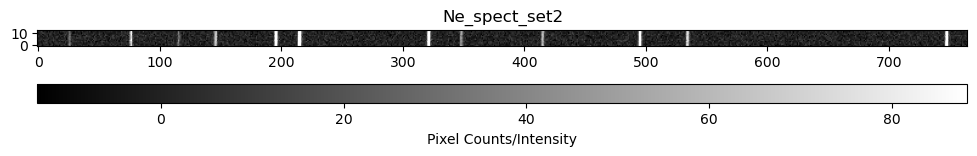

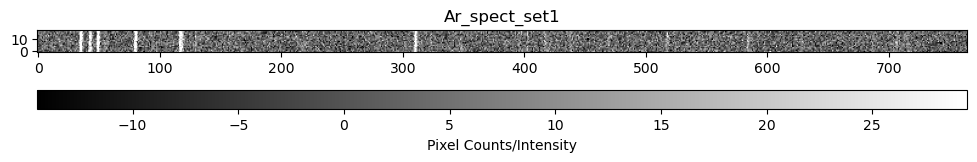

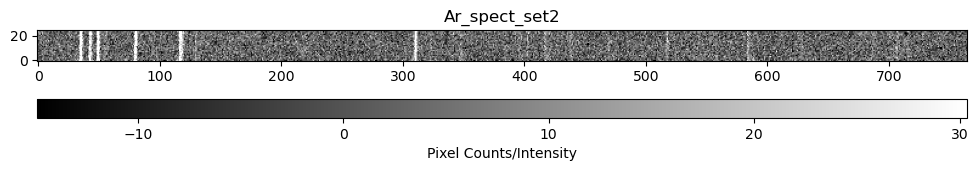

In [202]:
flats_cut = {'Ha_flat_set1' : cut_pixel_data_array(flats_dcorr['HaNe_flats_3s'], *cuts_dict['Ha_1']),
             'Ha_flat_set2' : cut_pixel_data_array(flats_dcorr['HaNe_flats_3s'], *cuts_dict['Ha_2']),
             'Hbg_flat_set1' : cut_pixel_data_array(flats_dcorr['HbgAr_flats_60s'], *cuts_dict['Hgb_1']),
             'Hbg_flat_set2' : cut_pixel_data_array(flats_dcorr['HbgAr_flats_60s'], *cuts_dict['Hgb_2']),
            }
spectra_cut = {'Ne_spect_set1' : cut_pixel_data_array(spectra_dcorr['neon_set1_15s'], *cuts_dict['Ha_1']),
               'Ne_spect_set2' : cut_pixel_data_array(spectra_dcorr['neon_set2_15s'], *cuts_dict['Ha_2']),
               'Ar_spect_set1' : cut_pixel_data_array(spectra_dcorr['argon_10s'], *cuts_dict['Hgb_1']),
               'Ar_spect_set2' : cut_pixel_data_array(spectra_dcorr['argon_10s'], *cuts_dict['Hgb_2']),
              }
for key,value in flats_cut.items():
    display_cut_spectrum(flats_cut[key], title=key)
    save_array_to_fits_file(flats_cut[key], path.join('cut_fits', 'flat_' +  key + '_cut.FIT'))
    
for key,value in spectra_cut.items():
    display_cut_spectrum(spectra_cut[key], title=key) 
    save_array_to_fits_file(spectra_cut[key], path.join('cut_fits', 'spect_' +  key + '_cut.FIT'))

### Flat Correction
Now it is time for the flat correction \
2)$\hspace{.02cm}$ Take the 2D array of the image data and find the median value of each column. This will create a 1D array with intensity values corresponding to horizontal pixel positions. \
3)$\hspace{.02cm}$ Plot the 1D array vs pixel position.

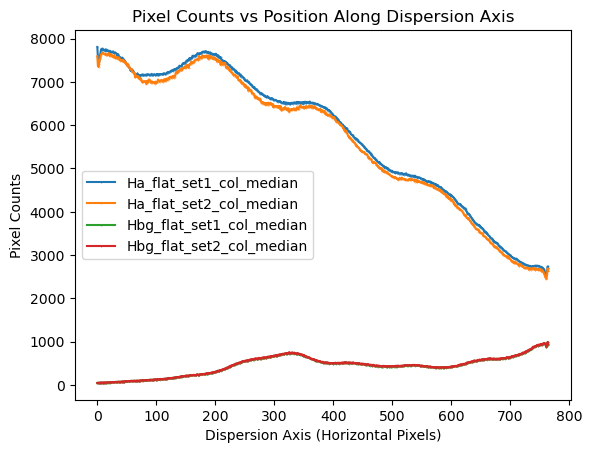

In [204]:
flat_field_col_medians = {}
for key,value in flats_cut.items():
    flat_field_col_medians[key+'_col_median'] = np.median(value, axis=0)
indices = np.arange(len(flat_field_col_medians['Ha_flat_set1_col_median']))

for key,value in flat_field_col_medians.items():
    plt.plot(indices, value, marker='.', ms=0.5, ls='solid', label=key)
    plt.title('Pixel Counts vs Position Along Dispersion Axis')
    plt.xlabel('Dispersion Axis (Horizontal Pixels)')
    plt.ylabel('Pixel Counts')
    plt.legend()
    plt.plot()

Now it is time to normalize the flat field

#### 4.4.2: Plot 1D Flat-Field Values vs Pixel Position (Along Dispersion Axis)
In this section we will take the following steps: \
1)$\hspace{.02cm}$ Cut the master flat-field to work with data only from the target $50 \mu m$ slit. \
2)$\hspace{.02cm}$ Take the 2D array of the image data and find the median value of each column. This will create a 1D array with intensity values corresponding to horizontal pixel positions. \
3)$\hspace{.02cm}$ Plot the 1D array vs pixel position.

#### 4.4.3: Normalize The Flat Fields
Since we cannot know whether the variation in flat-field brightness is due to the relative sensitivity of pixels or from the arclamp spectrum itself, we will have to normalize the flat-field along the dispersion axis by fitting a polynomial to our 1d flat-field array and then divide our cut out flat-field by this fit.

C:\Users\antho\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\antho\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\antho\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\antho\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


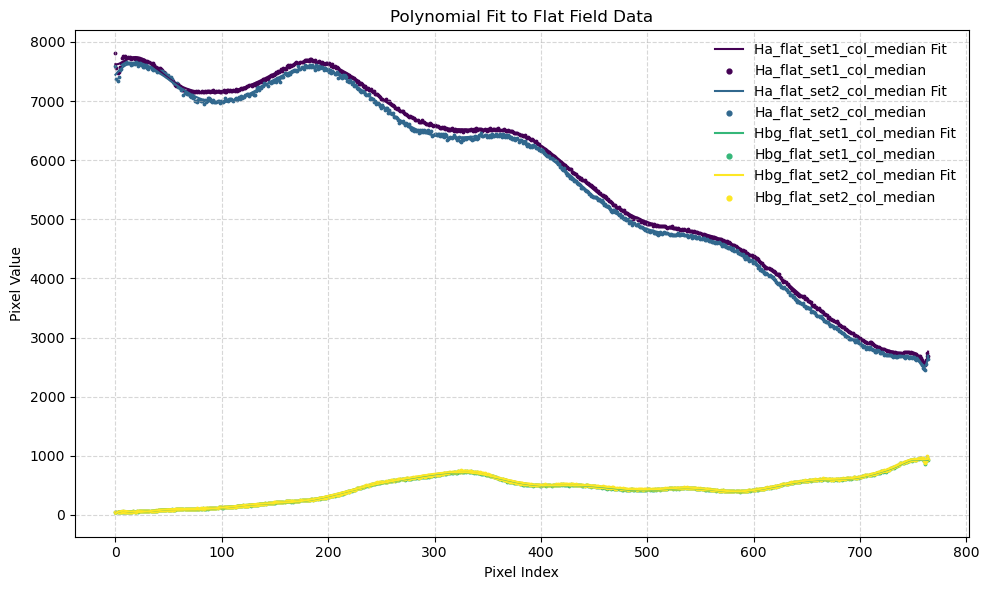

In [209]:
specific_plot = False
specific_plot_label = 'Ha_flat_set2'
#specific_plot_label = 'Hbg_flat_set1'
os.makedirs('normalized_fits', exist_ok=True)
normalized_flat_fields = {}
degree = 50
fig, ax = plt.subplots(figsize=(10,6))
colors = plt.cm.viridis(np.linspace(0, 1, len(flat_field_col_medians))) #plasma viridis

for i, ((key, values), (flat_key, flat_values)) in enumerate(zip(flat_field_col_medians.items(), flats_cut.items())): 
    if specific_plot:
        if flat_key != specific_plot_label:  # Change the condition to choose which set to display
            continue
    coefficients = np.polyfit(indices, values, deg=degree)
    polynomial_fit = np.polyval(coefficients, indices)
    polynomial_fit_2d = np.tile(polynomial_fit, (flat_values.shape[0], 1))

    ax.plot(indices, polynomial_fit, color=colors[i], label=f'{key} Fit')
    ax.scatter(indices, values, marker='o', s=3, color=colors[i], label=f'{key}')
    ax.set_ylabel('Pixel Value')
    ax.set_xlabel('Pixel Index')
    ax.set_title('Polynomial Fit to Flat Field Data')
    ax.grid(True, which='both', linestyle='--', alpha=0.5)  # Add gridlines
    plt.legend()
    
    normalized_flat_fields[flat_key] = flat_values / polynomial_fit_2d
    save_array_to_fits_file(normalized_flat_fields[flat_key], path.join('normalized_fits', 'norm_' +  flat_key + '.FIT'))
    
ax.legend(loc='upper right', frameon=False, fontsize=10, markerscale=2)
# Show the plot
plt.tight_layout()  # Adjusts layout to fit everything
plt.show()

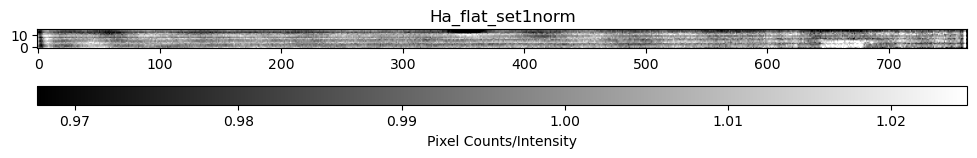

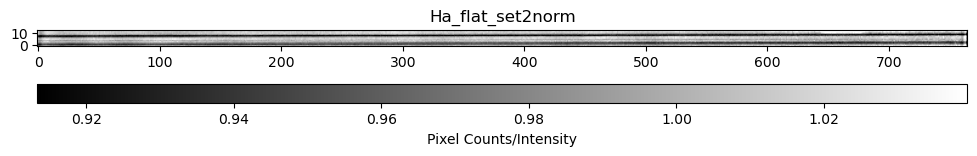

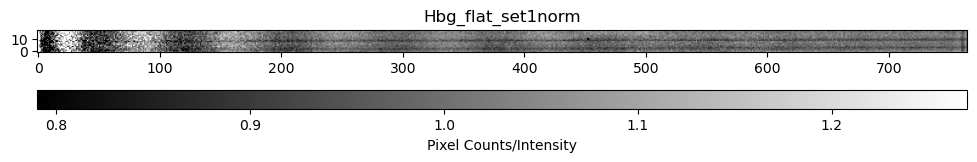

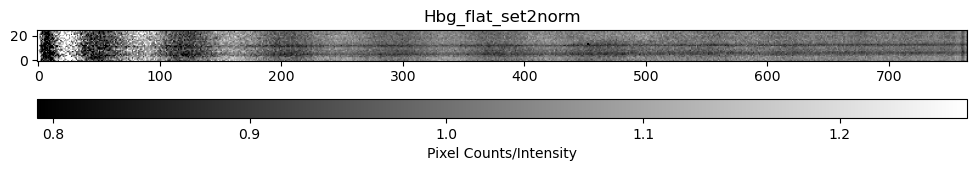

In [210]:
for key, values in normalized_flat_fields.items():
    display_cut_spectrum(values, title=key+'norm')

Text(0.5, 1.0, 'Non-Normalized Flat Field')

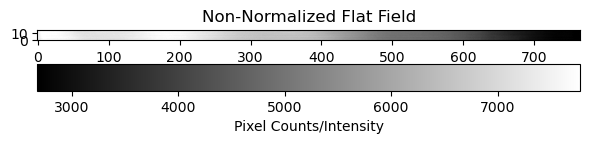

In [211]:
display_2d_array(flats_cut['Ha_flat_set1'])
plt.title('Non-Normalized Flat Field')

Text(0.5, 1.0, 'Normalized Flat Field')

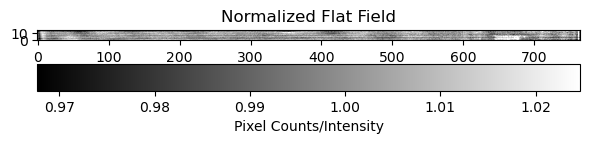

In [212]:
display_2d_array(normalized_flat_fields['Ha_flat_set1'])
plt.title('Normalized Flat Field')

Now we have to finish calibrating our spectra (both sci and calibration) by dividing by the flat field

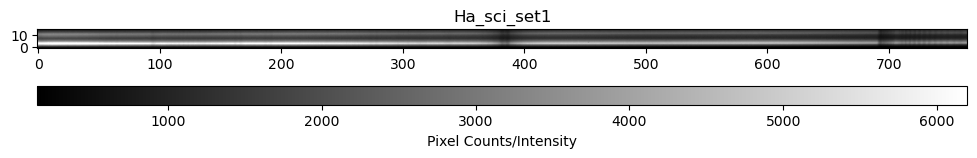

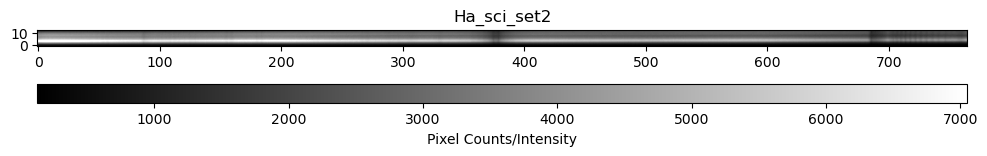

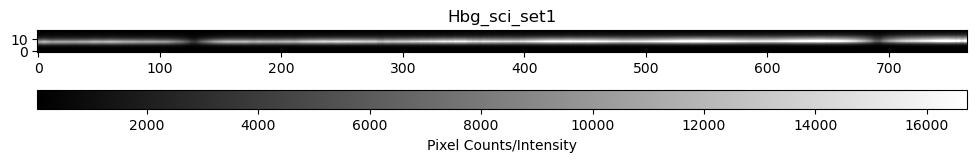

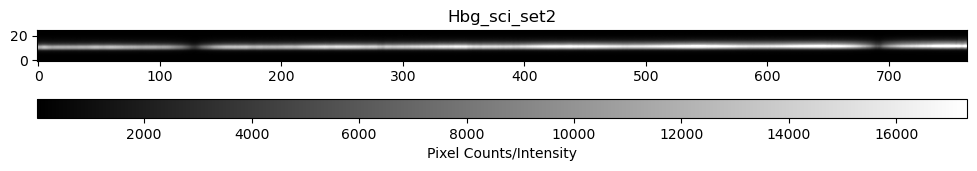

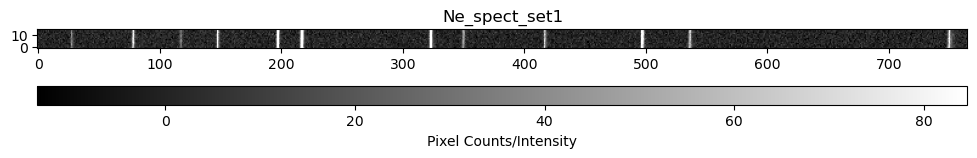

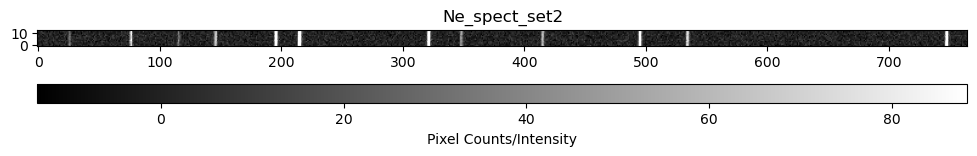

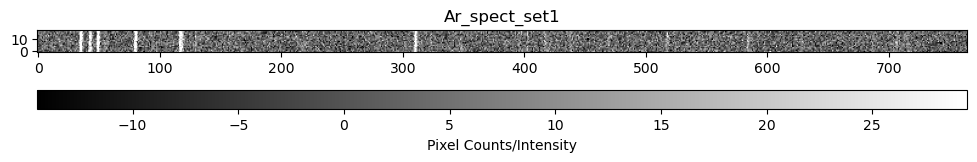

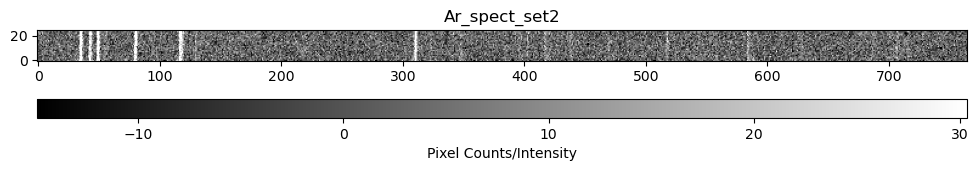

In [214]:
calibrated_science = sci_cut.copy()
calibrated_spectra = spectra_cut.copy()
os.makedirs('finalized_spectra', exist_ok=True)
for (key, value), (flat_key, flat_value) in zip(calibrated_science.items(), normalized_flat_fields.items()):
    calibrated_science[key] = value / flat_value     
    display_cut_spectrum(value, title=key)
    save_array_to_fits_file(value, path.join('finalized_spectra',f'calibrated_{key}.FIT'))
for (key, value), (flat_key, flat_value) in zip(calibrated_spectra.items(), normalized_flat_fields.items()):
    calibrated_spectra[key] = value / flat_value     
    display_cut_spectrum(value, title=key)
    save_array_to_fits_file(value, path.join('finalized_spectra',f'calibrated_{key}.FIT'))


## Wavelength Calibration
First, we matched spectral lines from our spectrum to emission lines of the actual neon spectrum, and we made a list of pixel positions that lined up with emission wavelengths from the NIST website.
We will show how to fit a linear function to a plot of pixel positions vs wavelength to derive a wavelength calibration formula. 

Index(['x_pixel_set1', 'x_pixel_set2', 'wavelength', 'delta'], dtype='object')
Ne_x_index_set1==> Slope: 0.099, Intercept: 618.888
Ne_x_index_set2==> Slope: 0.099, Intercept: 619.005


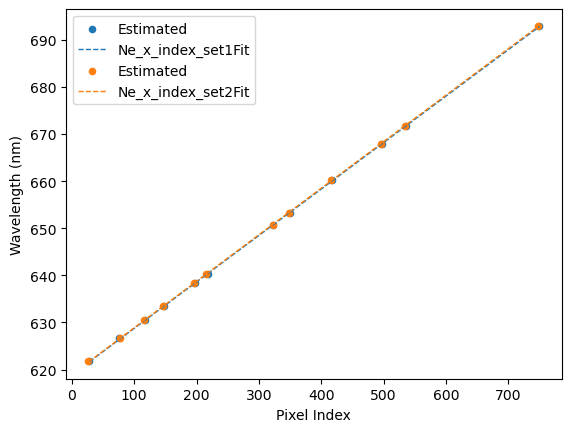

In [216]:
def pixel_to_wavelength_index(x,slope,b):
    return slope*x + b
    
pix_vs_wavelength = pd.read_csv('Ne_pixels_vs_wavelength.csv')
print(pix_vs_wavelength.columns)
pix_vs_wavelength['Ne_x_index_set1'] = pix_vs_wavelength['x_pixel_set1'] - 1 ###Why was I subtracting 1?
pix_vs_wavelength['Ne_x_index_set2'] = pix_vs_wavelength['x_pixel_set2'] - 1

indices = ['Ne_x_index_set1', 'Ne_x_index_set2']
wavelengths = pix_vs_wavelength['wavelength']
calibration_stats = {}
for index in indices:
    x_index = pix_vs_wavelength[index]
    slope, intercept = np.polyfit(x_index, wavelengths, 1)
    calibration_stats[index] = [slope, intercept]
    plt.scatter(x_index, wavelengths, marker='o', s=20, label='Estimated')
    plt.plot(x_index, pixel_to_wavelength_index(x_index, slope, intercept), ls='--', lw=1.0, label=index+'Fit')
    plt.ylabel('Wavelength (nm)')
    plt.xlabel('Pixel Index')
    #plt.yticks(np.arange(590,671,10))
    #plt.xticks(np.arange(40,600,50))
    plt.legend()
    print(f'{index}==> Slope: {slope:.3f}, Intercept: {intercept:.3f}')

Index(['x_pixel', 'wavelength', 'all_wavelengths'], dtype='object')
    x_pixel  wavelength  all_wavelengths  Ar_x_index_set1  Ar_x_index_set2
0   37.0000   425.93620        425.11850          36.0000          36.0000
1   44.3398   426.65265        425.93620          43.3398          43.3398
2   50.7600   427.21690        426.65265          49.7600          49.7600
3   82.2900   430.92385        427.21690          81.2900          81.2900
4  119.0000   433.11992        427.75279         118.0000         118.0000
5  129.6000   434.00000        430.92385         128.6000         128.6000
6  311.5000   451.07330        433.11992         310.5000         310.5000
7  692.3280   486.10000        434.00000         691.3280         691.3280
Ar_x_index_set1==> Slope: 0.092, Intercept: 422.665
Ar_x_index_set2==> Slope: 0.092, Intercept: 422.665


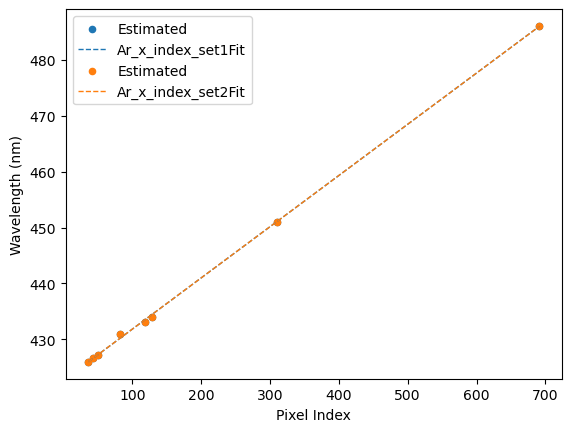

In [217]:
pix_vs_wavelength = pd.read_csv('Ar_pixels_vs_wavelength.csv').dropna()
print(pix_vs_wavelength.columns)
pix_vs_wavelength['Ar_x_index_set1'] = pix_vs_wavelength['x_pixel'] - 1 ###Why was I subtracting 1?
pix_vs_wavelength['Ar_x_index_set2'] = pix_vs_wavelength['Ar_x_index_set1'].copy()
print(pix_vs_wavelength)
indices = ['Ar_x_index_set1', 'Ar_x_index_set2']
wavelengths = pix_vs_wavelength['wavelength']
for index in indices:
    x_index = pix_vs_wavelength[index]
    slope, intercept = np.polyfit(x_index, wavelengths, 1)
    calibration_stats[index] = [slope, intercept]
    plt.scatter(x_index, wavelengths, marker='o', s=20, label='Estimated')
    plt.plot(x_index, pixel_to_wavelength_index(x_index, slope, intercept), ls='--', lw=1.0, label=index+'Fit')
    plt.ylabel('Wavelength (nm)')
    plt.xlabel('Pixel Index')
    #plt.yticks(np.arange(590,671,10))
    #plt.xticks(np.arange(40,600,50))
    plt.legend()
    print(f'{index}==> Slope: {slope:.3f}, Intercept: {intercept:.3f}')

## Plot Calibrated Spectrum and Science Spectra

In [219]:
for key in calibration_stats.items(): print(key)

('Ne_x_index_set1', [0.09855494474948531, 618.8876538651871])
('Ne_x_index_set2', [0.09872051184568467, 619.0054423327665])
('Ar_x_index_set1', [0.09165163100599666, 422.66497366117744])
('Ar_x_index_set2', [0.09165163100599666, 422.66497366117744])


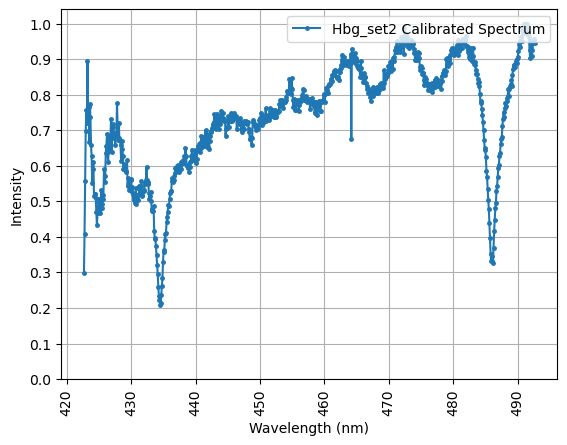

In [220]:
##### Normalize Spectra to be capped at 1 (for visualizing separately)
normalized_spectra = {'Ne_set1' : np.median(calibrated_spectra['Ne_spect_set1'], axis=0) / np.max(np.median(calibrated_spectra['Ne_spect_set1'], axis=0)),
                      'Ne_set2' : np.median(calibrated_spectra['Ne_spect_set2'], axis=0) / np.max(np.median(calibrated_spectra['Ne_spect_set2'], axis=0)),
                      'Ha_set1' : np.sum(calibrated_science['Ha_sci_set1'], axis=0) / np.max(np.sum(calibrated_science['Ha_sci_set1'], axis=0)),
                      'Ha_set2' : np.sum(calibrated_science['Ha_sci_set2'], axis=0) / np.max(np.sum(calibrated_science['Ha_sci_set2'], axis=0)),
                      'Ar_set1' : np.median(calibrated_spectra['Ar_spect_set1'], axis=0) / np.max(np.median(calibrated_spectra['Ar_spect_set1'], axis=0)),
                      'Ar_set2' : np.sum(calibrated_spectra['Ar_spect_set2'], axis=0) / np.max(np.sum(calibrated_spectra['Ar_spect_set2'], axis=0)),
                      'Hbg_set1' : np.sum(calibrated_science['Hbg_sci_set1'], axis=0) / np.max(np.sum(calibrated_science['Hbg_sci_set1'], axis=0)),
                      'Hbg_set2' : np.sum(calibrated_science['Hbg_sci_set2'], axis=0) / np.max(np.sum(calibrated_science['Hbg_sci_set2'], axis=0)),
                     }
#spectrum_label = 'Ne_set1'
spectrum_label = 'Hbg_set2' #normalized spectrum to use
index_set = 'Ar_x_index_set2' #calibration statistics to use
spectrum_index = np.arange(len(normalized_spectra[spectrum_label])) #pixel index
spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[index_set]) #pixel index --> wavelength index


'''
#Find Peaks
peaks, _ = find_peaks(normalized_spectra[spectrum_label], height=(0.0,.4))  # Customize height threshold if needed
#print(peaks)
for peak in peaks:
    plt.annotate(f'{spectrum_wavelength_index[peak]:.1f} nm', 
                 (spectrum_wavelength_index[peak], normalized_spectra[spectrum_label][peak]), 
                 xytext=(0, 4), textcoords='offset points', ha='center', fontsize=7, color='red')
#'''


plt.plot(spectrum_wavelength_index, normalized_spectra[spectrum_label], label=spectrum_label+' Calibrated Spectrum', marker='.', ms=5)
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.yticks(np.arange(0.0,1.1,0.1))
plt.xticks(rotation = 90)

#plt.xlim(655.0, 657.0)

#Zoom in to a regiOn
#plt.xlim(655, 658)
#plt.xlim(484,488)
#plt.ylim(0.3, 0.5)

#Plot Balmer Lines:
#plt.vlines(x=656.3, ymin=0, ymax=1, color='r')
#plt.vlines(x=486.1, ymin=0, ymax=1, color='cyan')
#plt.vlines(x=434, ymin=0, ymax=1, color='blue')

plt.legend(loc='upper right')
plt.grid(True)
#434 486.1 656.3

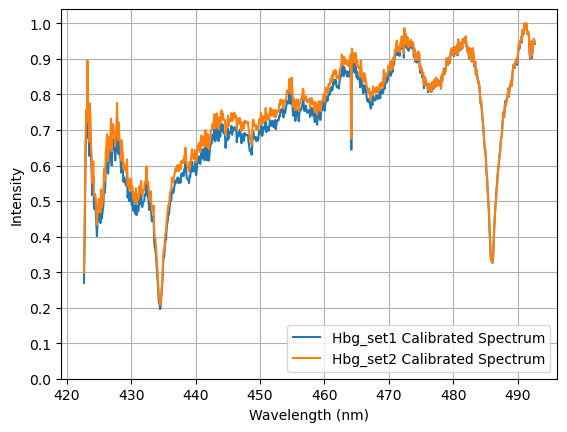

In [221]:
#View Stacked Spectra
spectrum_labels = ['Hbg_set1','Hbg_set2'] #['Ha_set1','Ha_set2','Hbg_set1', 'Hbg_set2'] 
index_sets = ['Ar_x_index_set1','Ar_x_index_set2']#['Ne_x_index_set1','Ne_x_index_set2','Ar_x_index_set1','Ar_x_index_set2'] #calibration_stats['']

for (s_label, i_set) in zip(spectrum_labels, index_sets):
    spectrum_index = np.arange(len(normalized_spectra[s_label]))
    spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[i_set])
    plt.plot(spectrum_wavelength_index, normalized_spectra[s_label], label=s_label+' Calibrated Spectrum')

'''
#Find Peaks
peaks, _ = find_peaks(normalized_spectra[spectrum_label], height=(0,.35))  # Customize height threshold if needed
#print(peaks)
for peak in peaks:
    plt.annotate(f'{spectrum_wavelength_index[peak]:.1f} nm', 
                 (spectrum_wavelength_index[peak], normalized_spectra[spectrum_label][peak]), 
                 xytext=(0, 4), textcoords='offset points', ha='center', fontsize=7, color='red')
'''

plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.yticks(np.arange(0.0,1.1,0.1))
#plt.xticks(np.arange(420,500,5),rotation=90)
#plt.xticks(np.arange(420,500,5),rotation=90)

#Zoom in to a regiOn
#plt.xlim(684, 690)
#plt.ylim(0.2, 0.9)

#Plot Balmer Lines:
#plt.vlines(x=656.3, ymin=0, ymax=1, color='r', label='H$\\alpha$')
#plt.vlines(x=486.1, ymin=0, ymax=1, color='cyan', label='H$\\beta$')
#plt.vlines(x=434, ymin=0, ymax=1, color='blue', label='H$\\gamma$')

plt.legend(loc='lower right')
plt.grid(True)
#434 486.1 656.3

In [222]:
spectrum_length_nm = spectrum_wavelength_index[-1]-spectrum_wavelength_index[0]
print(f'The length of the spectrum is {(10.0 * spectrum_length_nm):.3f} Angstroms')
print(f'The dispersion of the spectrograph is {(10.0*spectrum_length_nm)/(len(spectrum_index)):.3f} Angstroms/Pixel')

The length of the spectrum is 700.218 Angstroms
The dispersion of the spectrograph is 0.915 Angstroms/Pixel


0.314
656.802
1.230
[[ 8.91295268e-05  2.99140090e-06 -2.40925218e-04]
 [ 2.99140090e-06  1.81878101e-03 -2.88933280e-05]
 [-2.40925218e-04 -2.88933280e-05  1.90569069e-03]]


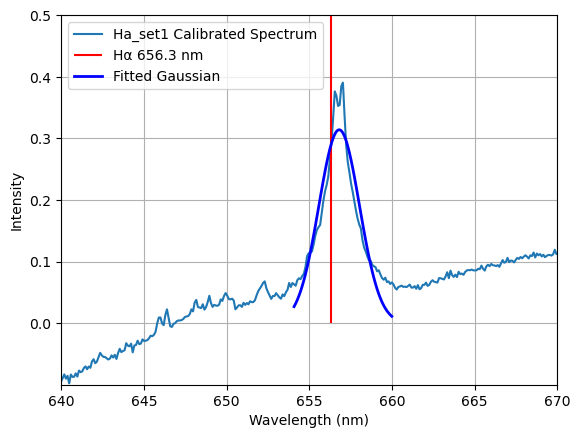

In [223]:
def wavelength_to_pixel_index(wavelength, slope, b):
    return (wavelength - b) / slope
def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu)**2) / (2 * sigma**2))

#spectrum settings
spectrum_label = 'Ha_set1'
index_set = 'Ne_x_index_set1'
spectrum_index = np.arange(len(normalized_spectra[spectrum_label]))
spectrum_wavelength_index = pixel_to_wavelength_index(spectrum_index, *calibration_stats[index_set])

#plot spectrum
dy = -0.2
plot_spectrum(spectrum_label=spectrum_label, index_set=index_set, plot_Habg_balmer=[True,False,False], xlim=[640,670], ylim=[-0.1,.5], invert_spectrum=True, dy=dy)

#Set bounds
xmin = 654
xmax = 660
mask = (spectrum_wavelength_index >= xmin) & (spectrum_wavelength_index <= xmax)
xdata = spectrum_wavelength_index[mask]  # Filter xdata
ydata = (-1.0 * normalized_spectra[spectrum_label] + 1.0 + dy)[mask]  # Apply the same mask to ydata

#Guess and get parameters
initial_guess = [0.35, 656.3, 0.1]
params, params_covariance = curve_fit(gaussian, xdata=xdata, ydata=ydata, p0=initial_guess)
for i in params: print(f'{i:.3f}')
print(params_covariance)

#Plot Gaussian
plt.plot(xdata, gaussian(xdata, *params), label='Fitted Gaussian', color='blue', lw=2)
plt.legend()